In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os.path
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

import nltk.data
#nltk.download()

In [2]:
# Read data from files 
train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print("Read {} labeled train reviews, {} labeled test reviews, " \
    "and {} unlabeled reviews\n".format(train["review"].size,
                                    test["review"].size, 
                                    unlabeled_train["review"].size))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [3]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review, "html.parser").get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [4]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [5]:
sentences_file = "sentences.pickle"
sentences = []

if os.path.isfile(sentences_file):
    with open(sentences_file, 'rb') as f:
        sentences = pickle.load(f)

In [6]:
if not sentences:
    sentences = []  # Initialize an empty list of sentences

    print("Parsing sentences from training set...")
    for review in train["review"]:
        sentences += review_to_sentences(review, tokenizer)

    print("Parsing sentences from unlabeled set...")
    for review in unlabeled_train["review"]:
        sentences += review_to_sentences(review, tokenizer)

    with open(sentences_file, 'wb') as f:
        pickle.dump(sentences, f, pickle.HIGHEST_PROTOCOL)

In [7]:
len(sentences)

795538

In [8]:
print(sentences[0])

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']


In [9]:
print(sentences[1])

['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


In [10]:
word2vec_file = "word2vec_model.pickle"
model = None

if os.path.isfile(word2vec_file):
    with open(word2vec_file, 'rb') as f:
        model = pickle.load(f)

In [11]:
if not model:
    # Import the built-in logging module and configure it so that Word2Vec 
    # creates nice output messages
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    # Set values for various parameters
    num_features = 100    # Word vector dimensionality
    min_word_count = 50   # Minimum word count
    num_workers = 2       # Number of threads to run in parallel
    context = 5           # Context window size                               
    downsampling = 1e-3   # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)
    from gensim.models import word2vec
    print("Training model...")
    model = word2vec.Word2Vec(sentences, workers=num_workers,
                              size=num_features, min_count = min_word_count,
                              window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model_name = "100features_50minwords_5context"
    model.save(model_name)

    with open(word2vec_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

2016-12-04 19:22:40,414 : INFO : Pattern library is not installed, lemmatization won't be available.
2016-12-04 19:22:40,438 : INFO : Could not import Theano, will use standard float for default ShardedCorpus dtype.
2016-12-04 19:22:40,892 : INFO : 'pattern' package not found; tag filters are not available for English
2016-12-04 19:22:40,912 : INFO : collecting all words and their counts
2016-12-04 19:22:40,915 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-04 19:22:41,009 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2016-12-04 19:22:41,096 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types


Training model...


2016-12-04 19:22:41,191 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 30034 word types
2016-12-04 19:22:41,288 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 34348 word types
2016-12-04 19:22:41,380 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 37761 word types
2016-12-04 19:22:41,471 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 40723 word types
2016-12-04 19:22:41,557 : INFO : PROGRESS: at sentence #70000, processed 1561579 words, keeping 43333 word types
2016-12-04 19:22:41,641 : INFO : PROGRESS: at sentence #80000, processed 1780886 words, keeping 45714 word types
2016-12-04 19:22:41,724 : INFO : PROGRESS: at sentence #90000, processed 2004995 words, keeping 48135 word types
2016-12-04 19:22:41,807 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
2016-12-04 19:22:41,894 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 

In [15]:
model.similarity("woman", "girl")

0.82106420960043902

In [24]:
model.doesnt_match("movie batman star cat".split())

'movie'

In [38]:
import itertools
from collections import Counter

count_dict = Counter(itertools.chain(*sentences[:5000]))
count_dict.most_common(80)

[('the', 6295),
 ('a', 3148),
 ('and', 3077),
 ('of', 2784),
 ('to', 2524),
 ('is', 2125),
 ('it', 1791),
 ('in', 1789),
 ('i', 1617),
 ('this', 1434),
 ('that', 1411),
 ('s', 1368),
 ('with', 915),
 ('for', 856),
 ('as', 856),
 ('but', 840),
 ('was', 839),
 ('film', 798),
 ('movie', 793),
 ('on', 640),
 ('you', 607),
 ('t', 606),
 ('are', 567),
 ('one', 545),
 ('his', 532),
 ('he', 529),
 ('not', 523),
 ('be', 514),
 ('have', 509),
 ('all', 481),
 ('by', 462),
 ('at', 451),
 ('an', 423),
 ('her', 418),
 ('who', 417),
 ('from', 398),
 ('so', 397),
 ('like', 369),
 ('there', 362),
 ('has', 341),
 ('some', 338),
 ('they', 336),
 ('about', 331),
 ('or', 327),
 ('out', 326),
 ('just', 321),
 ('if', 318),
 ('good', 299),
 ('she', 277),
 ('very', 274),
 ('when', 266),
 ('more', 263),
 ('up', 259),
 ('can', 257),
 ('no', 252),
 ('what', 246),
 ('even', 245),
 ('really', 239),
 ('only', 238),
 ('time', 232),
 ('their', 230),
 ('which', 227),
 ('would', 226),
 ('my', 218),
 ('story', 216),
 ('w

In [86]:
def plot_similarity(model, words):
    from sklearn.manifold import TSNE
    
    X_frequent = model[words]
    model_tsne = TSNE(n_components=2, random_state=0)
    X_2D = model_tsne.fit_transform(X_frequent) 
    
    plt.plot(X_2D[:, 0], X_2D[:, 1], 'ro')

    for i, txt in enumerate(words):
        plt.annotate(txt, X_2D[i])

    plt.show()

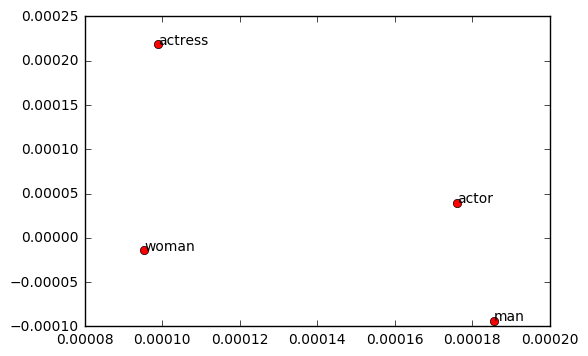

In [87]:
example_words = ["actor", "actress", "man", "woman"]
plot_similarity(model, example_words)

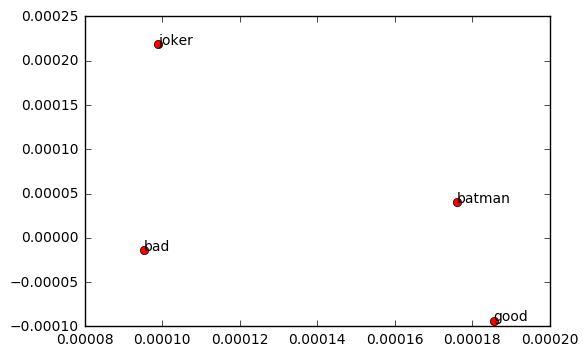

In [88]:
example_words = ["batman", "joker", "good", "bad"]
plot_similarity(model, example_words)